## IMPORTING CLEAN DATA & LIBRARIES

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Make the notebook's output stable across runs
np.random.seed(42)

# parallelization
from joblib import parallel_backend
from ray.util.joblib import register_ray
register_ray()

# models 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# evaluation
from sklearn import metrics

# parameter tuning 
from sklearn.model_selection import GridSearchCV

# getting the data
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

X_train = X_train.toarray()
X_test  = X_test.toarray()
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reducing Number of Datapoints for better model training times
X_train = np.resize(X_train, (100000, 1000))
y_train = np.resize(y_train, (100000,))
X_test  = np.resize(X_test, (42000, 1000))
y_test  = np.resize(y_test, (42000,))

# Note: Still stratified 

(raylet) [2022-05-19 22:02:47,249 E 74771 349897] (raylet) agent_manager.cc:107: The raylet exited immediately because the Ray agent failed. The raylet fate shares with the agent. This can happen because the Ray agent was unexpectedly killed or failed. See `dashboard_agent.log` for the root cause.
2022-05-19 22:03:15,629	WARNING worker.py:1382 -- The node with node id: 7d0bdb39074bfd60b67840a2609706e0f65e1f873e67a62c4f06bb89 and ip: 127.0.0.1 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.


In [2]:
# Helper Function for evaluation 
def evaluate(y_test, y_predict, model):
    print("\nMODEL: " + str(model))
    print('Accuracy: ', metrics.accuracy_score(y_test, y_predict))
    print("Precision: ", metrics.precision_score(y_test, y_predict))
    print("Recall: ", metrics.recall_score(y_test, y_predict))
    print("F1 Score: ", metrics.f1_score(y_test, y_predict))

    fpr, tpr, _ = metrics.roc_curve(y_test,  y_predict)
    auc = metrics.roc_auc_score(y_test, y_predict)

    # Plot ROC for this label
    plt.plot(fpr,tpr,label="AUC = "+ "{:.2f}".format(auc))
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## Naive Bayes

### DEFAULT

In [3]:
%%time
nb = GaussianNB()

with parallel_backend("ray"):
    nb.fit(X_train, y_train)

CPU times: user 1.39 s, sys: 999 ms, total: 2.39 s
Wall time: 2.42 s

MODEL: Naive Bayes
Accuracy:  0.6963095238095238
Precision:  0.6772273836537227
Recall:  0.752020538176286
F1 Score:  0.7126669820459103


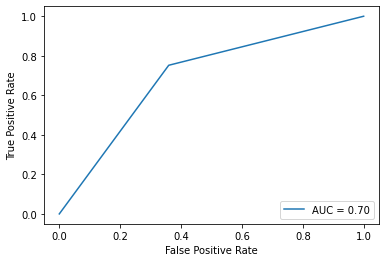

In [4]:
y_predict = nb.predict(X_test)
evaluate(y_test, y_predict, 'Naive Bayes')

### PARAMETER TUNING

In [ ]:
gridsearch_nb = GridSearchCV(estimator=GaussianNB(),
             param_grid={'var_smoothing': np.logspace(0, -9, num=100)},
             verbose=1, cv=5, n_jobs=-1)

with parallel_backend("ray"):
    gridsearch_nb.fit(X_train, y_train)
    
print("Best parameters: ", gridsearch_nb.best_params_)

## Logistic Regression

### DEFAULT

In [ ]:
%%time
lr = LogisticRegression()

with parallel_backend("ray"):
    lr.fit(X_train, y_train)

CPU times: user 790 ms, sys: 2.26 s, total: 3.05 s
Wall time: 37.3 s

MODEL: Logistic Regression
Accuracy:  0.7328095238095238
Precision:  0.7165430790960452
Recall:  0.7717980412665209
F1 Score:  0.7431448844129092


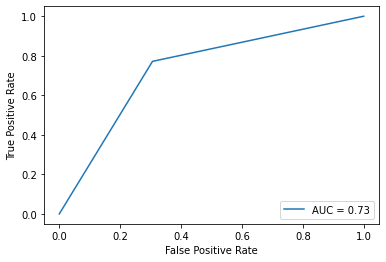

: 

In [6]:
y_predict = lr.predict(X_test)
evaluate(y_test, y_predict, 'Logistic Regression')

### PARAMETER TUNING

In [ ]:
gridsearch_lr = GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [100.0, 10.0, 1.0, 0.1, 0.01], 'solver': ['liblinear', 'lbfgs']},
             verbose=1, cv=5, n_jobs=-1)

with parallel_backend("ray"):
    gridsearch_lr.fit(X_train, y_train)
    
print("Best parameters: ", gridsearch_lr.best_params_)

## Long Short Term Memory Model (LSTM)